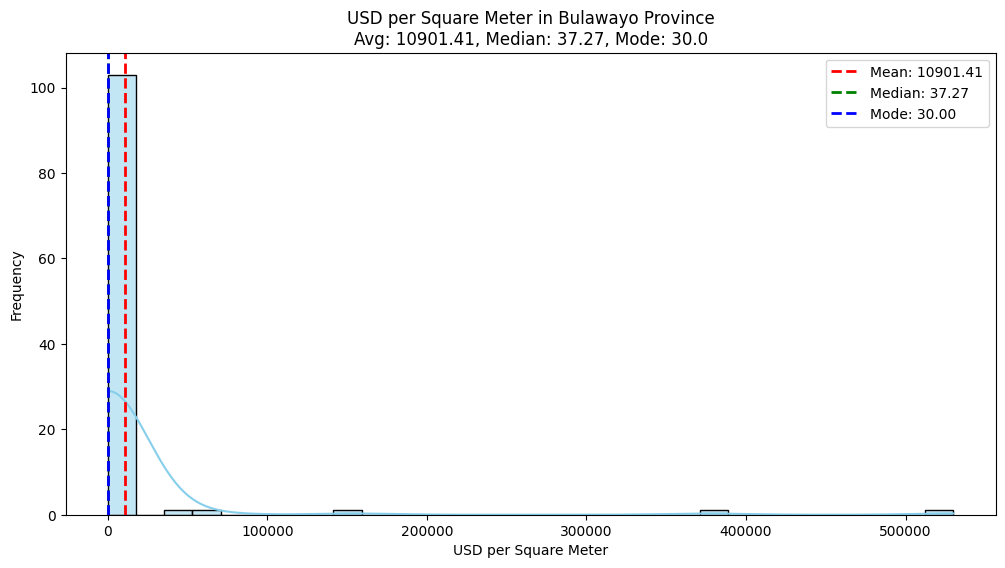

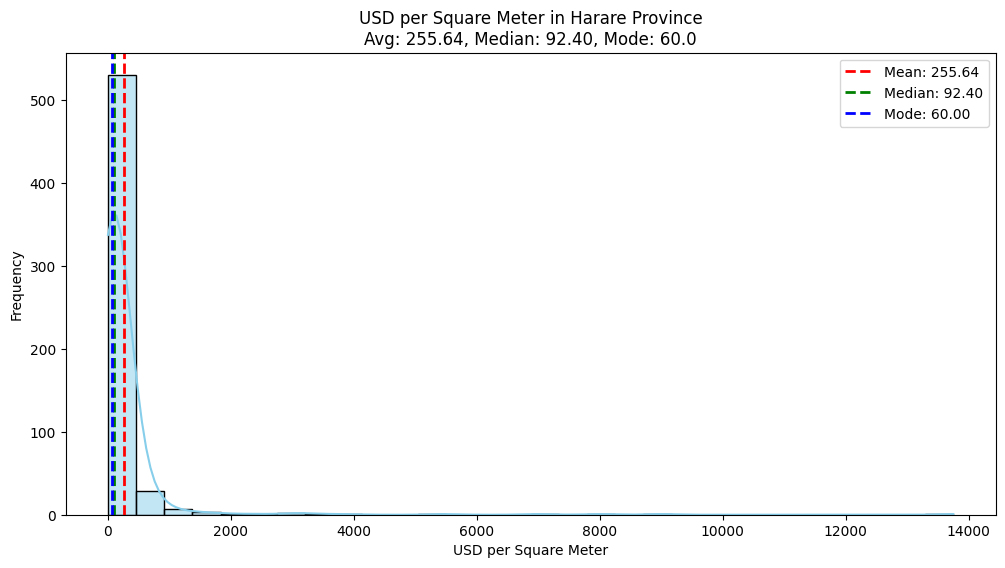

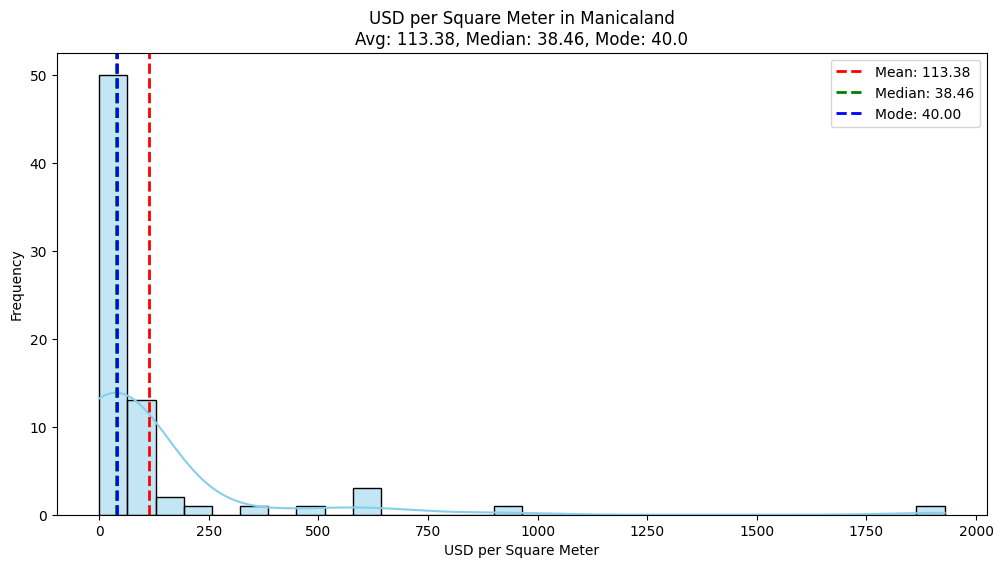

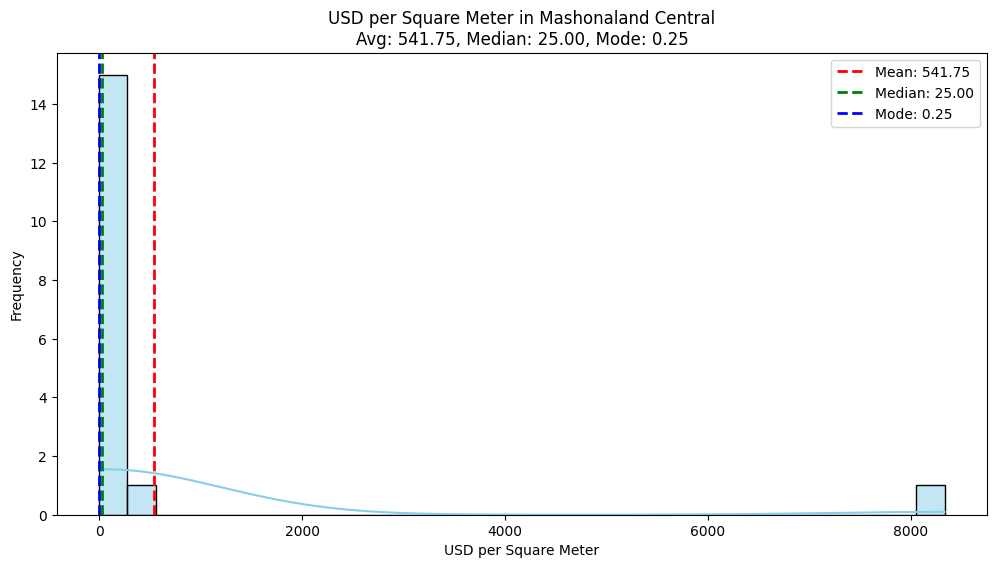

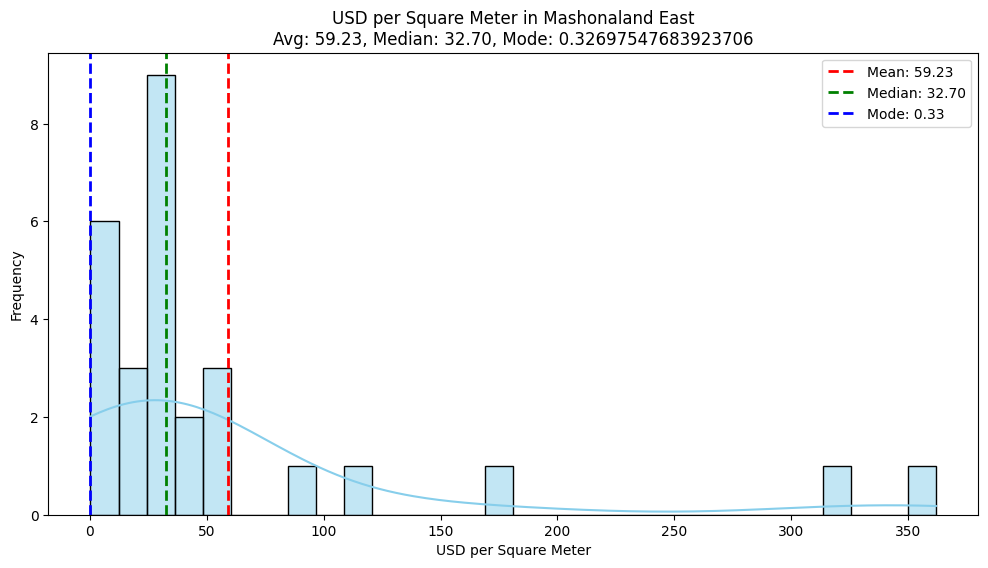

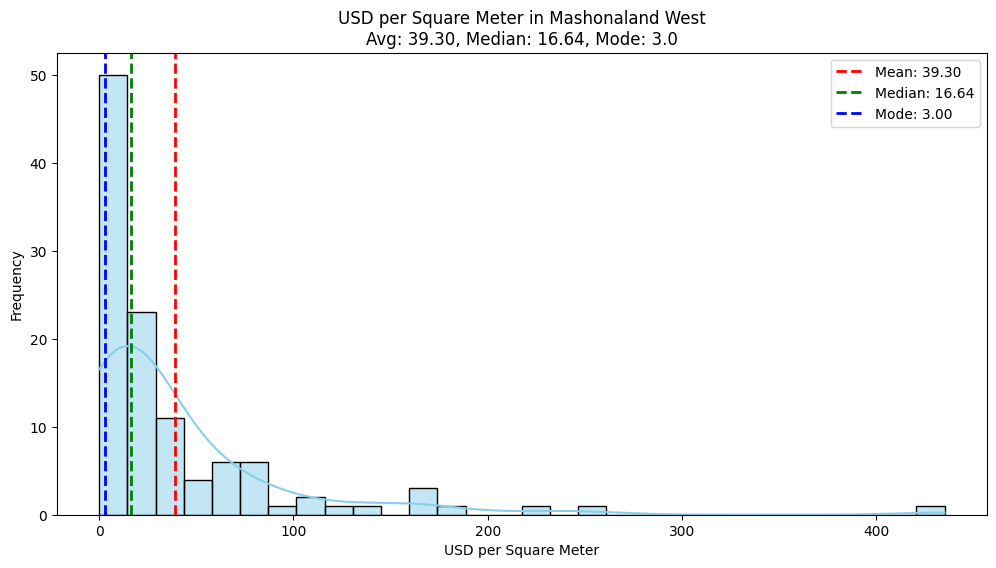

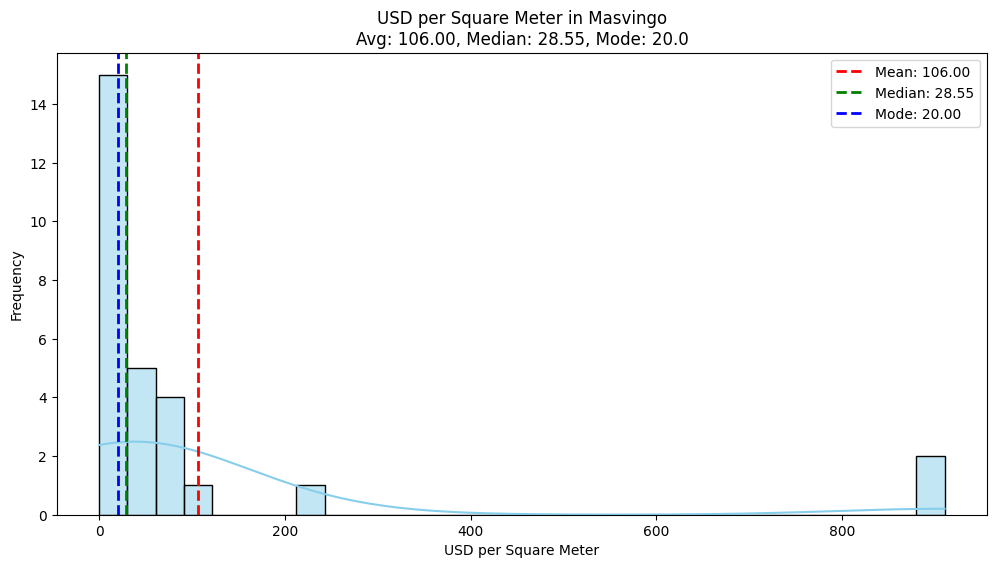

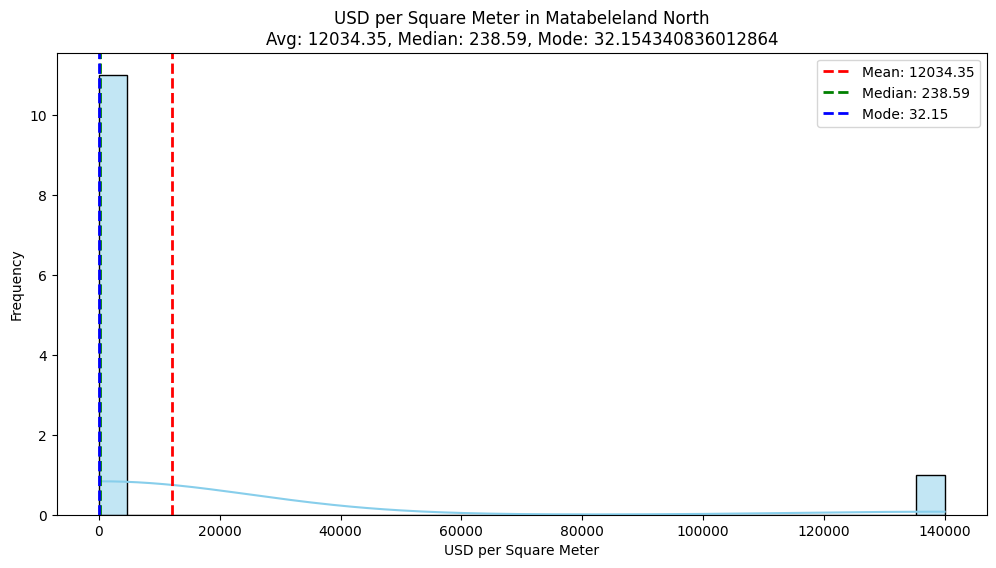

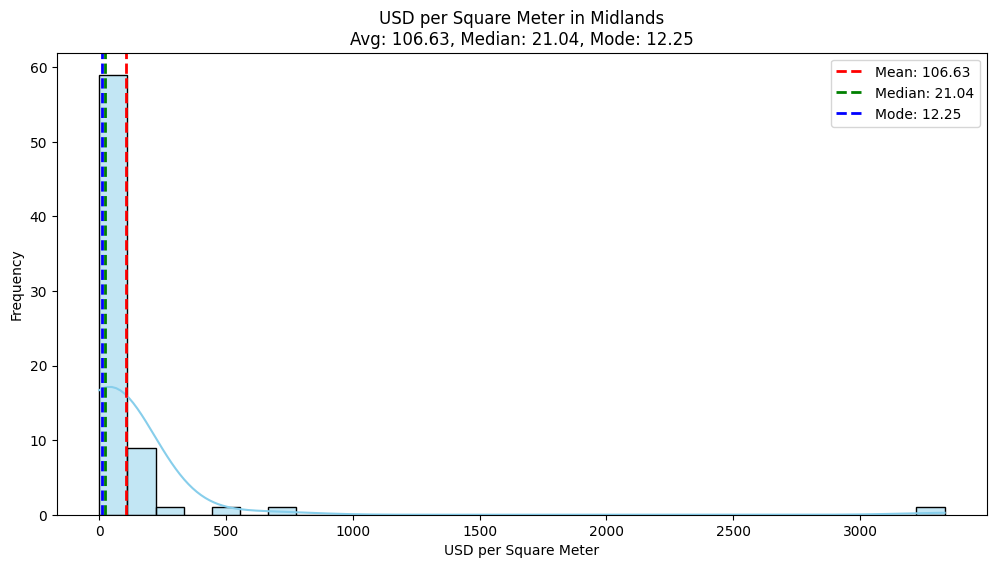

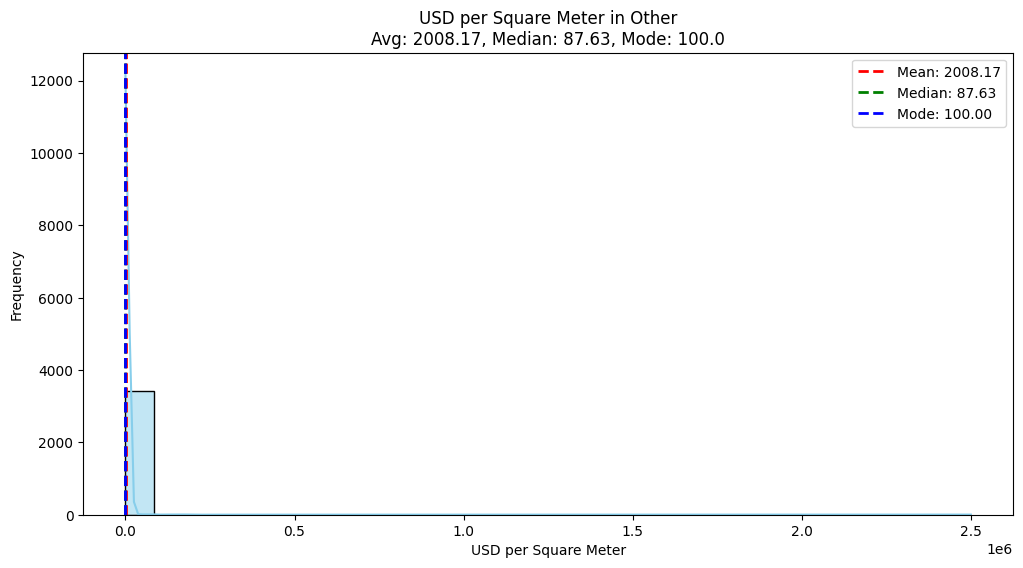

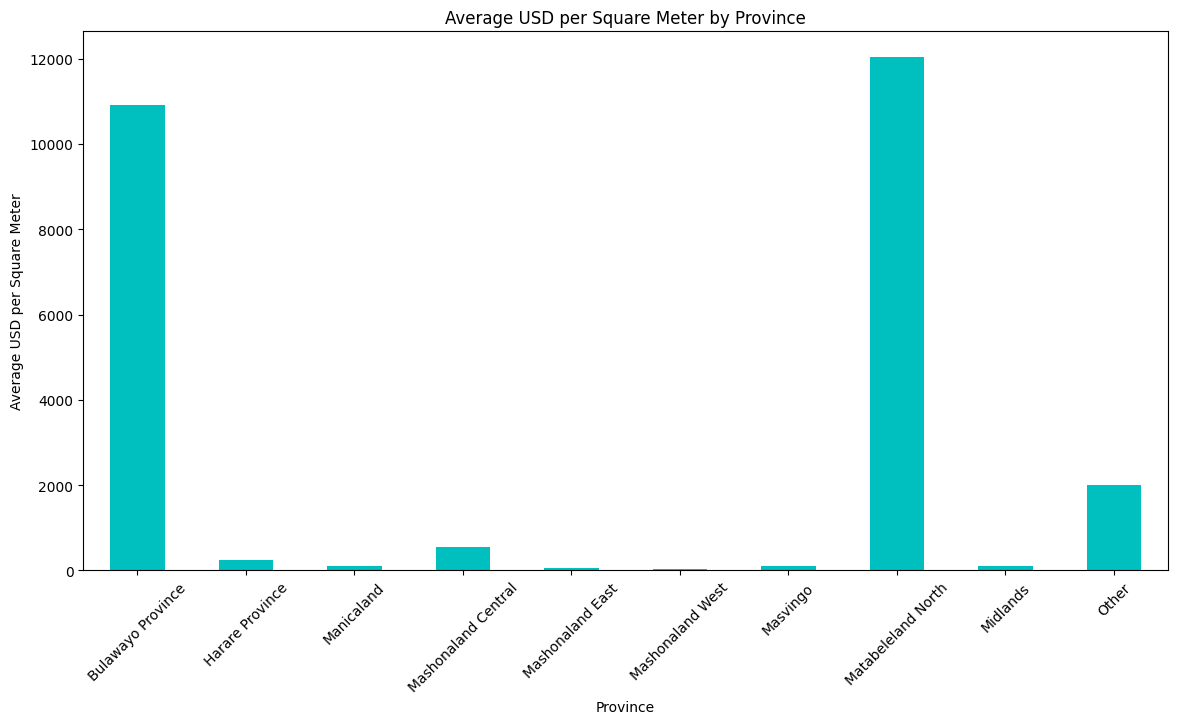

In [10]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Load the data
file_path = 'property_data.xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
df.head()

# Define the list of cities and their corresponding provinces
city_to_province = {
    'Harare': 'Harare Province',
    'Bulawayo': 'Bulawayo Province',
    'Mutare': 'Manicaland',
    'Gweru': 'Midlands',
    'Kwekwe': 'Midlands',
    'Masvingo': 'Masvingo',
    'Chinhoyi': 'Mashonaland West',
    'Marondera': 'Mashonaland East',
    'Kadoma': 'Mashonaland West',
    'Zvishavane': 'Midlands',
    'Victoria Falls': 'Matabeleland North',
    'Norton': 'Mashonaland West',
    'Chegutu': 'Mashonaland West',
    'Bindura': 'Mashonaland Central',
    'Redcliff': 'Midlands'
}

# Extract and standardize location
def extract_location(location):
    for city in city_to_province.keys():
        if re.search(fr'\b{city}\b', location, re.IGNORECASE):
            return city.title()
    return 'Other'

df['city'] = df['location'].apply(extract_location)
df['province'] = df['city'].apply(lambda city: city_to_province.get(city, 'Other'))

# Clean and convert price and size columns
def clean_price(price):
    try:
        return float(price.replace('USD', '').replace(',', '').strip())
    except:
        return None

def clean_size(size):
    try:
        return float(size.replace('m²', '').replace(',', '').strip())
    except:
        return None

df['clean_price'] = pd.to_numeric(df['price'].apply(clean_price), errors='coerce')
df['clean_size'] = pd.to_numeric(df['size'].apply(clean_size), errors='coerce')

# Calculate USD per square meter
df['usd_per_sqm'] = df.apply(lambda row: row['clean_price'] / row['clean_size'] if pd.notnull(row['clean_price']) and pd.notnull(row['clean_size']) and row['clean_size'] > 0 else None, axis=1)

# Drop rows with missing USD per square meter values
df = df.dropna(subset=['usd_per_sqm'])

# Function to remove outliers using IQR
def remove_outliers(data):
    Q1 = data['usd_per_sqm'].quantile(0.25)
    Q3 = data['usd_per_sqm'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data['usd_per_sqm'] >= lower_bound) & (data['usd_per_sqm'] <= upper_bound)]

# Remove outliers
df = remove_outliers(df)

# Group by province
province_groups = df.groupby('province')

# Function to plot statistics for each province
def plot_province_statistics(grouped_df):
    for province, group in grouped_df:
        avg_price = group['usd_per_sqm'].mean()
        median_price = group['usd_per_sqm'].median()
        mode_price = stats.mode(group['usd_per_sqm'])[0]
        mode_price = mode_price[0] if isinstance(mode_price, np.ndarray) and len(mode_price) > 0 else mode_price
        
        plt.figure(figsize=(12, 6))
        sns.histplot(group['usd_per_sqm'], bins=30, kde=True, color='skyblue')
        plt.axvline(avg_price, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {avg_price:.2f}')
        plt.axvline(median_price, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_price:.2f}')
        if isinstance(mode_price, (int, float)):
            plt.axvline(mode_price, color='b', linestyle='dashed', linewidth=2, label=f'Mode: {mode_price:.2f}')
        
        plt.title(f'USD per Square Meter in {province}\nAvg: {avg_price:.2f}, Median: {median_price:.2f}, Mode: {mode_price if isinstance(mode_price, (int, float)) else "N/A"}')
        plt.xlabel('USD per Square Meter')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

# Plot province statistics
plot_province_statistics(province_groups)

# Combined histogram for average USD per square meter across all provinces
avg_usd_per_sqm = province_groups['usd_per_sqm'].mean()

plt.figure(figsize=(14, 7))
avg_usd_per_sqm.plot(kind='bar', color='c')
plt.title('Average USD per Square Meter by Province')
plt.xlabel('Province')
plt.ylabel('Average USD per Square Meter')
plt.xticks(rotation=45)
plt.show()

# Save the cleaned and processed data to a new Excel file
df.to_excel('cleaned_property_data.xlsx', index=False)

